# Метод ближайших соседей

Для начала подключим библиотеки, которые нам понадобятся. Если библиотека не установлена, нужно выполнить команду:

!pip install <название библиотеки>

Например:

!pip install sklearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



Matplotlib is building the font cache; this may take a moment.


Загрузим данные из CSV-файла

In [3]:
data = pd.read_csv('D:\clients.csv', sep=',')
# Посмотрим на несколько записей из набора данных
data.head(10)

,month,credit_amount,credit_term,age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,male,Secondary special education,Cell phones,0,2,21000,Another,0,0,0
1,1,19000,6,20,male,Secondary special education,Household appliances,1,2,17000,Another,3,1,0
2,1,29000,12,23,female,Secondary special education,Household appliances,0,2,31000,Another,2,0,0
3,1,10000,12,30,male,Secondary special education,Cell phones,1,2,31000,Unmarried,3,1,0
4,1,14500,12,25,female,Higher education,Cell phones,0,2,26000,Married,0,1,0
5,1,32500,24,47,female,Secondary special education,Furniture,0,2,26000,Married,0,1,0
6,1,8000,3,23,male,Higher education,Computers,0,2,21000,Another,0,1,0
7,1,20000,10,25,female,Higher education,Household appliances,0,0,33000,Married,2,1,0
8,1,26000,6,21,female,Secondary special education,Cell phones,0,0,31000,Another,2,1,0
9,1,15000,24,25,female,Secondary special education,Household appliances,1,2,26000,Another,3,0,0


Этот набор данных - информация о клиентах магазина, совершающего покупку в рассрочку. В нашей работе будем выполнять задачу бинарной классификации. Предскажем значение переменной 'bad_client_target', которая означает, что клиент является ненадежным.
Для начала приведем таблицу в удобоваримый вид.

In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723 entries, 0 to 1722
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   month                1723 non-null   int64 
 1   credit_amount        1723 non-null   int64 
 2   credit_term          1723 non-null   int64 
 3   age                  1723 non-null   int64 
 4   sex                  1723 non-null   object
 5   education            1723 non-null   object
 6   product_type         1723 non-null   object
 7   having_children_flg  1723 non-null   int64 
 8   region               1723 non-null   int64 
 9   income               1723 non-null   int64 
 10  family_status        1723 non-null   object
 11  phone_operator       1723 non-null   int64 
 12  is_client            1723 non-null   int64 
 13  bad_client_target    1723 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 188.6+ KB


Выбросим за ненадобностью значения 'month', 'phone_operator', 'product_type', 'region'.

In [5]:
data = data.drop(['month', 'phone_operator', 'product_type', 'region'], axis='columns')



In [6]:
data.head(10)

,credit_amount,credit_term,age,sex,education,having_children_flg,income,family_status,is_client,bad_client_target
0,7000,12,39,male,Secondary special education,0,21000,Another,0,0
1,19000,6,20,male,Secondary special education,1,17000,Another,1,0
2,29000,12,23,female,Secondary special education,0,31000,Another,0,0
3,10000,12,30,male,Secondary special education,1,31000,Unmarried,1,0
4,14500,12,25,female,Higher education,0,26000,Married,1,0
5,32500,24,47,female,Secondary special education,0,26000,Married,1,0
6,8000,3,23,male,Higher education,0,21000,Another,1,0
7,20000,10,25,female,Higher education,0,33000,Married,1,0
8,26000,6,21,female,Secondary special education,0,31000,Another,1,0
9,15000,24,25,female,Secondary special education,1,26000,Another,0,0


Посмотрим, можем ли мы выбросить еще какие-нибудь признаки из нашей таблицы. Это стоит делать, поскольку чем меньше признаков - тем легче вычислять расстояние между объектами, то есть алгоритм будет работать быстрее. Посмотрим на корреляцию признаков между собой. Построим графическое представление модуля значения корреляции попарно между признаками.

<AxesSubplot:>

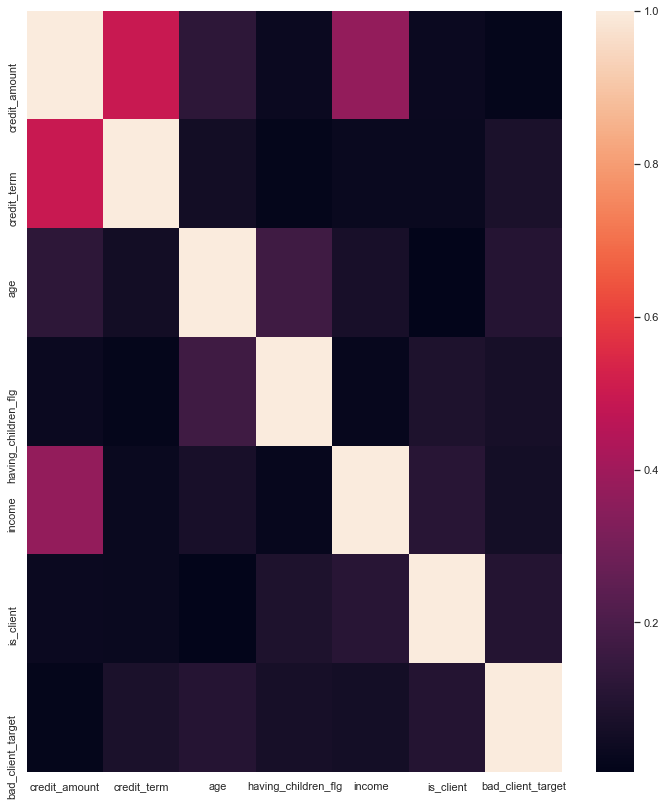

In [7]:
# Картинку отрисуем с помощью библиотеки seaborn
import seaborn as sns
# Подсчитаем корреляцию и возьмем модуль от нее
corr = data.corr().abs()
# Следующая команда устанавливает размер картинки (по умолчанию она довольно маленькая)
sns.set(rc={'figure.figsize':(12, 14)})
# Нарисуем картинку
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Видим колонки текстовых переменных. Посмотрим, сколько всего таких - выведем типы данных в каждой колонке.

In [8]:
data.dtypes

credit_amount           int64
credit_term             int64
age                     int64
sex                    object
education              object
having_children_flg     int64
income                  int64
family_status          object
is_client               int64
bad_client_target       int64
dtype: object

Текстовые признаки математическим методом не обработаешь. Посмотрим на значения, которые они принимают, чтобы придумать, что с ними делать.

In [9]:
data['sex'].value_counts()

male      931
female    792
Name: sex, dtype: int64

Заменим male на 1, а female на 0 

In [10]:
def gender_oppression(gender):
    if gender == 'male':
        return 1
    return 0

data['sex'] = data['sex'].apply(gender_oppression)

Посмотрим на полученные данные 

In [11]:
data.head()

,credit_amount,credit_term,age,sex,education,having_children_flg,income,family_status,is_client,bad_client_target
0,7000,12,39,1,Secondary special education,0,21000,Another,0,0
1,19000,6,20,1,Secondary special education,1,17000,Another,1,0
2,29000,12,23,0,Secondary special education,0,31000,Another,0,0
3,10000,12,30,1,Secondary special education,1,31000,Unmarried,1,0
4,14500,12,25,0,Higher education,0,26000,Married,1,0


Разберемся с колонками education и family_status. При анализе CSV в Excel в данной колонке выводятся следующие данные:
- Incomplete secondary education
- Secondary education
- Secondary special education
- Incomplete higher education
- Higher education
- PhD Degree
В колонке family_status видим следующее:
- Unmarried
- Married
- Another

In [12]:
def rename(edu):
    if edu == 'Incomplete secondary education':
        return 0
    if edu == 'Secondary education':
        return 1
    if edu == 'Secondary special education':
        return 2
    if edu == 'Incomplete higher education':
        return 3
    if edu == 'Higher education':
        return 4
    if edu == 'PhD Degree':
        return 5
    return 6

data['education'] = data['education'].apply(rename)

In [13]:
data.head()

,credit_amount,credit_term,age,sex,education,having_children_flg,income,family_status,is_client,bad_client_target
0,7000,12,39,1,2,0,21000,Another,0,0
1,19000,6,20,1,2,1,17000,Another,1,0
2,29000,12,23,0,2,0,31000,Another,0,0
3,10000,12,30,1,2,1,31000,Unmarried,1,0
4,14500,12,25,0,4,0,26000,Married,1,0


In [16]:
def rename(fs):
    if fs == 'Another':
        return 0
    if fs == 'Unmarried':
        return 1
    if fs == 'Married':
        return 2
    return 3

data['family_status'] = data['family_status'].apply(rename)

In [17]:
data.head()

,credit_amount,credit_term,age,sex,education,having_children_flg,income,family_status,is_client,bad_client_target
0,7000,12,39,1,2,0,21000,0,0,0
1,19000,6,20,1,2,1,17000,0,1,0
2,29000,12,23,0,2,0,31000,0,0,0
3,10000,12,30,1,2,1,31000,1,1,0
4,14500,12,25,0,4,0,26000,2,1,0


## Настало время machine learning

Выделим в нашей выборке целевую переменную, а также разделим ее на тренировочную и тестовую.

In [19]:
X = data[data.columns[:-1]]
y = data['bad_client_target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

Пора заняться делом. Будем проводить классификацию с помощью метода ближайших соседей.

In [20]:
# импортируем класс классификатора по ближайшим соседям
from sklearn.neighbors import KNeighborsClassifier

# создадим наш классификатор. Гиперпараметр у этого алгоритма один - количество соседей.
clf = KNeighborsClassifier(n_neighbors=6)
# обучим классификатор на тренировочной выборке
clf.fit(X_train, y_train)
# подсчитаем долю верных ответов алгоритма на тестовой выборке.
# Есть и другие метрики качества - о них будет рассказано на следующей лабе
clf.score(X_test, y_test)

0.8863109048723898

Посмотрим, как влияет гиперпараметр на качество классификации.

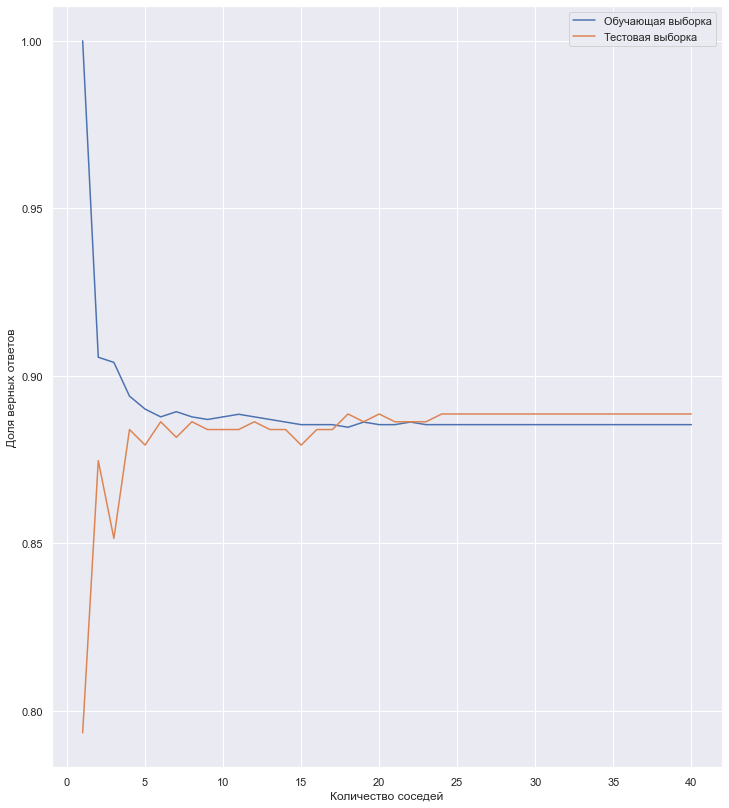

In [21]:
# Создадим пустой словарь. Будем добавлять в него значения наших "скоров". Ключами будет значение гиперпараметра,
# значениями - качество работы. Рассмотрим отдельно качество на тренировочной выборке и на тестовой.
train_scores = {}
test_scores = {}

# для n в диапазоне от 1 до 40 включительно
for n in range(1, 41):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train, y_train)
    # значение качества на текущей итерации:
    current_train_score = clf.score(X_train, y_train)
    current_test_score = clf.score(X_test, y_test)
    # запишем его в наши словари
    train_scores[n] = current_train_score
    test_scores[n] = current_test_score

# нарисуем графики

plt.plot(list(train_scores.keys()), list(train_scores.values()), label='Обучающая выборка')
plt.plot(list(test_scores.keys()), list(test_scores.values()), label='Тестовая выборка')
plt.xlabel('Количество соседей')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


Исходя из полученных данных, можно сделать вывод, что при количестве не менее 6 соседей мы получаем наилучшую точность